# Initialising notebook

In [117]:
# import packages required for this project
import pandas as pd
import numpy as np
from collections import Counter


# nlp packages: nltk, re, gensim, spellchecker
import re
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from spellchecker import SpellChecker

# machine learning packages: sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing


# visualisation packages: matplotlib, seaborn, adjustText
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
from wordcloud import WordCloud

# download extras for nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
nltk.download('stopwords')

# define stopwords and lemmatizer
stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/livernteo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/livernteo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/livernteo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/livernteo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [118]:
# read full dataset
df = pd.read_csv('nyc_stop_question_frisk_2021.csv')

# Data Preprocessing

This section addresses data quality concerns in the dataset. It

* drops rows with `NaN` values
* changes all `'(null)'` to `'N'` for columns which are meant to have `Y/N` values
* changes all `'(null)'` to `'OTHER'` for columns that are categorical

In [121]:
# drop rows with NaN
df = df.copy().dropna()

# for consistency, where field is flag, replace '(null)' with 'N'
flag_columns = ['FRISKED_FLAG', 'SEARCHED_FLAG', 'ASK_FOR_CONSENT_FLG', 'CONSENT_GIVEN_FLG', 'OTHER_CONTRABAND_FLAG', 'FIREARM_FLAG', 'KNIFE_CUTTER_FLAG', 'OTHER_WEAPON_FLAG', 'WEAPON_FOUND_FLAG', 'PHYSICAL_FORCE_CEW_FLAG', 'PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG', 'PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG', 'PHYSICAL_FORCE_OC_SPRAY_USED_FLAG', 'PHYSICAL_FORCE_OTHER_FLAG', 'PHYSICAL_FORCE_RESTRAINT_USED_FLAG', 'PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG', 'PHYSICAL_FORCE_WEAPON_IMPACT_FLAG']

for c in flag_columns:
    df[c] = df[c].replace('(null)', 'N')

# columns where '(null)' should be replaced with 'OTHER'
other_columns = ['SUSPECT_RACE_DESCRIPTION']

for c in other_columns:
    df[c] = df[c].replace('(null)', 'OTHER')

# columns where '(null)' should be replaced with NaN
nan_columns = ['DEMEANOR_OF_PERSON_STOPPED', 'SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_ARREST_OFFENSE']

for c in nan_columns:
    df[c] = df[c].replace('(null)', np.NaN)

# 1. Introduction and Exploratory Data Analysis
This section contains the EDA conducted for the report. It:

* Calculates the percentage make up of stops by race
* Calculates the percentage make up of stops by race, normalised to the population demographic in New York City
* Calculates the likelihood of experiencing 'severe' physical force by race
* Calculates the words in the `DEMEANOR_OF_PERSON_STOPPED` column with the highest occurance

## 1.1: Percentage make up of stops by race, and normalised to the population demographic of New York City

In [122]:
# total number of observations
total_obs = len(df)

# calculate percentage make up of stops by race and save to dataframe
fig1a_df = df.groupby('SUSPECT_RACE_DESCRIPTION').count()['STOP_ID']/total_obs*100
fig1a_df.rename('Percentage', inplace=True)
fig1a_df = fig1a_df.reset_index().sort_values('Percentage', ascending=False)
fig1a_df

,SUSPECT_RACE_DESCRIPTION,Percentage
2,BLACK,60.206939
7,WHITE HISPANIC,19.330493
6,WHITE,8.630554
3,BLACK HISPANIC,8.131467
1,ASIAN / PACIFIC ISLANDER,2.081558
4,MIDDLE EASTERN/SOUTHWEST ASIAN,0.815581
5,OTHER,0.718198
0,AMERICAN INDIAN/ALASKAN NATIVE,0.085210


In [123]:
# demographics of new york city as provided by the 2021 census
demographics_df = pd.DataFrame.from_dict({
    'WHITE':2614667,
    'BLACK':1714326,
    'NATIVE':14810,
    'ASIAN / PACIFIC ISLANDER':1213642,
    'OTHER':445948,
    'HISPANIC':2464120
}, orient='index', columns=['population'])

# function to match race in NYPD report to race in census
def match_race_to_census(race_desc):
    if (race_desc == 'BLACK HISPANIC') or (race_desc == 'WHITE HISPANIC'):
        return 'HISPANIC'
    elif race_desc == 'AMERICAN INDIAN/ALASKAN NATIVE':
        return 'NATIVE'
    elif race_desc == 'MIDDLE EASTERN/SOUTHWEST ASIAN':
        return 'ASIAN / PACIFIC ISLANDER'
    else:
        return race_desc

# create new column in dataframe with matched race in census
df['race_census'] = df['SUSPECT_RACE_DESCRIPTION'].apply(lambda x: match_race_to_census(x))

# calculate stops as a percentage of demographics in NYC and save to dataframe
fig1b_df = pd.merge(demographics_df, df['race_census'].value_counts(), left_index=True, right_index=True)
fig1b_df['Percentage'] = fig1b_df['race_census'] / fig1b_df['population']*100
fig1b_df = fig1b_df.reset_index().sort_values('Percentage', ascending=False)
fig1b_df = fig1b_df.rename({'index':'SUSPECT_RACE_DESCRIPTION'}, axis=1)
fig1b_df

,SUSPECT_RACE_DESCRIPTION,population,race_census,Percentage
1,BLACK,1714326,4946,0.288510
5,HISPANIC,2464120,2256,0.091554
2,NATIVE,14810,7,0.047265
0,WHITE,2614667,709,0.027116
3,ASIAN / PACIFIC ISLANDER,1213642,238,0.019610
4,OTHER,445948,59,0.013230


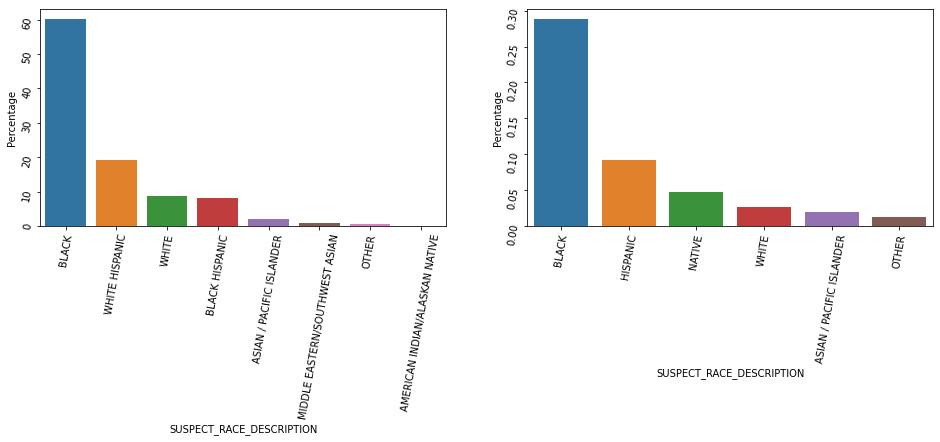

In [124]:
# create plot for Figure 1 (as seen in report)
fig, ax =plt.subplots(1,2,figsize=(16,4))

# left plot
sns.barplot(fig1a_df, x='SUSPECT_RACE_DESCRIPTION', y='Percentage', ax=ax[0])
ax[0].tick_params(labelrotation=80)

# right plot
sns.barplot(fig1b_df,x='SUSPECT_RACE_DESCRIPTION', y='Percentage', ax=ax[1])
ax[1].tick_params(labelrotation=80)

## 1.2: Likelihood of severe physical force being used in stops

In [125]:
# initialise empty list for severe physical force column
severe_physical_force = []

# list of columns where severe physical force was used (defined by author to be tasers, pepper spray, firearms
# and weapons impact
severe_physical_force_cols = ['PHYSICAL_FORCE_CEW_FLAG', 'PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG','PHYSICAL_FORCE_OC_SPRAY_USED_FLAG', 'PHYSICAL_FORCE_WEAPON_IMPACT_FLAG']

# iterate over the dataframe
for _, row in df.iterrows():
    physical_force = []
    # get Y/N flags for the severe physical force columns
    for c in severe_physical_force_cols:
        physical_force.append(row[c])

    if 'Y' in physical_force:
        severe_physical_force.append('Y')
    else:
        severe_physical_force.append('N')

# create new column with list
df['severe_physical_force'] = severe_physical_force

# count instances of severe physical force by race
fig2_df = df.groupby(['SUSPECT_RACE_DESCRIPTION', 'severe_physical_force'])\
    .count()['STOP_ID']\
    .reset_index()\
    .rename({'STOP_ID':'severe_force_count'}, axis=1)

# get the number of stops by race
fig2_df = pd.merge(fig2_df,
                   df.groupby(['SUSPECT_RACE_DESCRIPTION'])\
                   .count()['STOP_ID']\
                   .reset_index()\
                   .rename({'STOP_ID':'total_stops'}, axis=1))

# calculate percentage breakdown of severe physical force by total number of stops by race
fig2_df['percentage'] = fig2_df['severe_force_count']/fig2_df['total_stops']*100

# get percentage of stops where severe physical forcce was used
fig2_df = fig2_df[fig2_df['severe_physical_force'] == 'Y']
# omit rows with less than 200 (~2%) of observations
fig2_df = fig2_df[fig2_df['total_stops']>200]
fig2_df = fig2_df.sort_values('percentage')
fig2_df

,SUSPECT_RACE_DESCRIPTION,severe_physical_force,severe_force_count,total_stops,percentage
7,BLACK HISPANIC,Y,30,668,4.491018
13,WHITE,Y,38,709,5.359661
15,WHITE HISPANIC,Y,94,1588,5.919395
5,BLACK,Y,346,4946,6.995552


(array([0, 1, 2, 3]),
 [Text(0, 0, 'BLACK HISPANIC'),
  Text(1, 0, 'WHITE'),
  Text(2, 0, 'WHITE HISPANIC'),
  Text(3, 0, 'BLACK')])

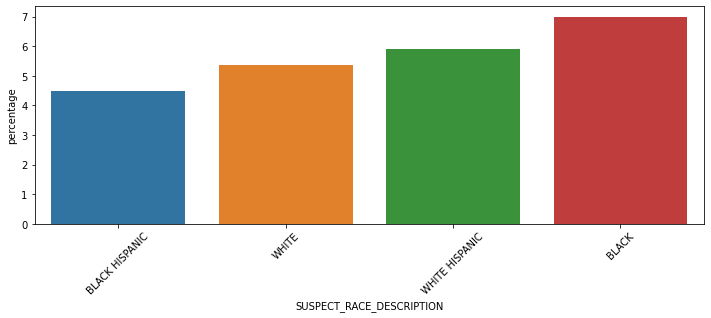

In [126]:
# Plot of likelihood black, hispanic and white suspects were to experience severe physical force
plt.figure(figsize=(12,4))
sns.barplot(fig2_df, x='SUSPECT_RACE_DESCRIPTION', y='percentage')
plt.xticks(rotation=45)

## 1.3. Word occurance in `DEMEANOR_OF_PERSON_STOPPED`


In [127]:
spell = SpellChecker()
def correct_spelling(sentence):
    '''
    Function to correct spelling of words in a sentence
    :param sentence: string to be spell checked
    :return: string with mispelled words replaced
    '''

    if sentence is not np.nan:
        # remove punctuation and tokenize (required for SpellChecker)
        tokens = re.findall(r'\b\w\w+\b', sentence)

        # get list of potentially mispelled words
        misspelled = spell.unknown(tokens)

        for word in misspelled:
            # if misspelled word exists, identify likely correction
            correction = spell.correction(word)
            if correction:
                # if correction exists apply correction, else ignore
                sentence = sentence.replace(word.upper(), spell.correction(word).upper())

    return sentence


In [128]:
%%time
## Perform spell check on demeanor of person stopped column ~20 seconds
df['DEMEANOR_OF_PERSON_STOPPED_v2'] = df['DEMEANOR_OF_PERSON_STOPPED'].apply(lambda x: correct_spelling(x))

CPU times: user 19.7 s, sys: 326 ms, total: 20.1 s
Wall time: 23.7 s


In [129]:
# initialise an empty string
all_descriptions = ''

for _, row in df.iterrows():
    if row['DEMEANOR_OF_PERSON_STOPPED_v2'] is not np.nan:
        # iterate over df and add all demeanor descriptions to string
        all_descriptions = all_descriptions + ' ' + str(row['DEMEANOR_OF_PERSON_STOPPED_v2'])

# generate word cloud
wordcloud = WordCloud(background_color='white', collocations=False).generate(all_descriptions)

# use Counter to count words in all_descriptions
Counter = Counter(all_descriptions.split())

# find the top 20 most common words
most_occur = Counter.most_common(20)

# format most_occur to a dataframe for visualisation
most_occur_df = pd.DataFrame(most_occur, columns=['Word', 'Count']).set_index('Word')
# remove stop words
most_occur_df = most_occur_df.drop([w.upper() for w in stopwords], errors='ignore')

(-0.5, 399.5, 199.5, -0.5)

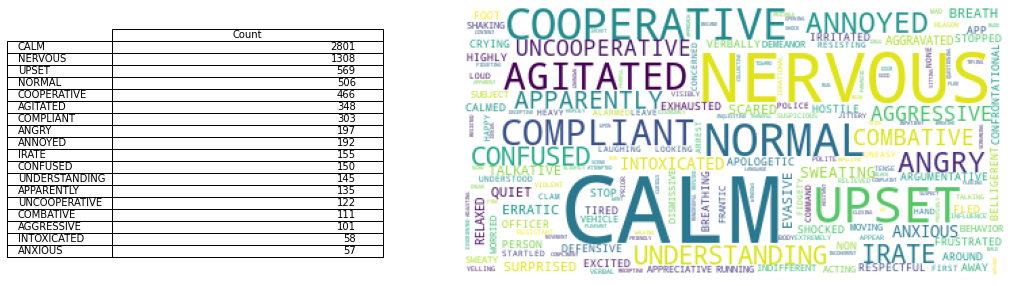

In [130]:
# initialise subplots
fig, ax = plt.subplots(1,2,figsize=(16,5), gridspec_kw={'width_ratios': [1, 2]})

# left plot
ax[0].table(cellText=most_occur_df.values, colLabels=most_occur_df.columns, rowLabels=most_occur_df.index, loc='center')
ax[0].axis('off')
ax[0].axis('tight')

# right plot
ax[1].imshow(wordcloud)
ax[1].axis("off")

# 2. Self-trained word embeddings model

This section goes through the process of training a word embedding model with the `20-newgroups` dataset to obtain word/document vectors for the `DEMEANOR_OF_PERSON_STOPPED` column


In [131]:
def preprocess(sentence):
    '''
    Performs to following preprocessing on a sentence:
    * making all words lower case
    * removing punctuation and single character words
    * removing stop words
    * lemmatisation of words

    :param sentence; string
    :return: processed tokens; list
    '''

    # make sentence lower case
    sentence= sentence.lower()

    # filter out punctuations and single character words
    tokens = re.findall(r'\b\w\w+\b', sentence)

    # remove stop words
    tokens = [t for t in tokens if t not in stopwords]

    # lemming
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return tokens

### 2.1 Train a word embedding model with `20-newsgroups` dataset

In [132]:
# get the 20 news groups dataset from sklearn
news_dataset = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))
news_df = pd.DataFrame({'article': news_dataset.data,
                        'target': news_dataset.target})
# perform preprocessing on the articles
news_df['tokens'] = news_df['article'].apply(lambda x: preprocess(x))
news_df.head(10)

,article,target,tokens
0,I was wondering if anyone out there could enli...,7,"[wondering, anyone, could, enlighten, car, saw..."
1,A fair number of brave souls who upgraded thei...,4,"[fair, number, brave, soul, upgraded, si, cloc..."
2,"well folks, my mac plus finally gave up the gh...",4,"[well, folk, mac, plus, finally, gave, ghost, ..."
3,\nDo you have Weitek's address/phone number? ...,1,"[weitek, address, phone, number, like, get, in..."
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,"[article, c5owcb, n3p, world, std, com, tombak..."
5,\n\n\n\n\nOf course. The term must be rigidly...,16,"[course, term, must, rigidly, defined, bill, d..."
6,There were a few people who responded to my re...,13,"[people, responded, request, info, treatment, ..."
7,...,3,"[show, know, much, scsi, scsi, scsi, controler..."
8,I have win 3.0 and downloaded several icons an...,2,"[win, downloaded, several, icon, bmp, figure, ..."
9,"\n\n\nI've had the board for over a year, and ...",4,"[board, year, work, diskdoubler, autodoubler, ..."


In [133]:
%%time
# initialise empty list
corpus = []

# iterate over dataframe and append tokens to corpus, creating a list of lists
for _, row in news_df.iterrows():
    corpus.append(row['tokens'])

# trains a Word2Vec model with the corpus which trains on words that occur at least 5 times in the corpus
# and produces a 2 dimensional vector; ~ 10 seconds
self_trained_model = Word2Vec(corpus, min_count=5, vector_size=2)

CPU times: user 8.93 s, sys: 202 ms, total: 9.13 s
Wall time: 4.86 s


### 2.2 Pre-processing `df`

In [134]:
# drop rows where 'DEMEANOR_OF_PERSON_STOPPED_v2' is null
df= df.dropna(subset=['DEMEANOR_OF_PERSON_STOPPED_v2'])
# preprocessing DEMEANOR_OF_PERSON_STOPPED_v2
df['demeanor_tokens'] = df['DEMEANOR_OF_PERSON_STOPPED_v2'].apply(lambda x: preprocess(x))

In [135]:
self_trained_df = df.copy()

### 2.3 Get document vectors for each demeanor description

Document vectors are obtained by

* Determining the vector per word in obsveration
* Calculating the average of all word vectors

In [136]:
def get_demeanor_vector(model, tokens):
    '''

    Function that returns a document vectors for a given modela dn document
    :param model; Word2Vec model
    :param tokens; list
    :return: vector
    '''

    total_vectors = []
    for token in tokens :
        try:
            total_vectors.append(model[token])
        except KeyError:
            # if token is out of vocabulary then continue to the next token
            continue

    return np.mean(total_vectors, axis=0)


In [137]:
self_trained_df['vectors'] = self_trained_df['demeanor_tokens'].apply(lambda x: get_demeanor_vector(self_trained_model.wv, x))

/Users/livernteo/Documents/Imperial - Machine Learning and Data Science/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [138]:
n_oov_rows = self_trained_df['vectors'].isna().sum()
print(f'Number of rows where vectors could not be determied due to out of vocabulary words: {n_oov_rows}')

# drop rows where vectors were not found
self_trained_df = self_trained_df.dropna(subset=['vectors'])

Number of rows where vectors could not be determied due to out of vocabulary words: 657


In [139]:
# separate vectors to x and y component
self_trained_df['x'] = self_trained_df['vectors'].apply(lambda x: x[0])
self_trained_df['y'] = self_trained_df['vectors'].apply(lambda x: x[1])

### 2.4 Get the vectors for the top 10 most common words in dataset

In [140]:
# get top 10 most common words
top_10 = most_occur_df.head(10).copy()

vec = []
for i, _ in top_10.iterrows():
    # iterate and find the vector for each word
    vec.append(get_demeanor_vector(self_trained_model.wv, [i.lower()]))

# create new column for vectors
top_10['vector'] = vec

# drop row if any of the top 10 words were out of vocabulary
top_10 = top_10.dropna()

# separate vectors to x and y component
top_10['x'] = top_10['vector'].apply(lambda x:x[0])
top_10['y'] = top_10['vector'].apply(lambda x:x[1])

/Users/livernteo/Documents/Imperial - Machine Learning and Data Science/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/livernteo/Documents/Imperial - Machine Learning and Data Science/venv/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### 2.5 Plot document vectors from `self_trained_df` and overlay with location of top 10 most common words

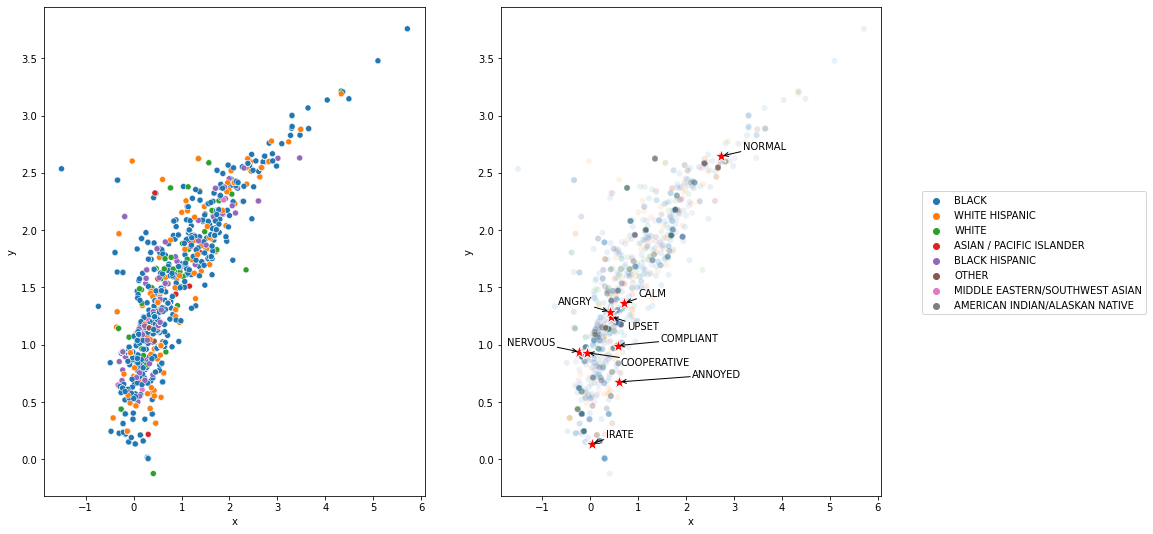

In [141]:
# initialise subplots
fig, ax = plt.subplots(1,2,figsize=(15,9))

# left plot
sns.scatterplot(self_trained_df, x='x', y='y', hue='SUSPECT_RACE_DESCRIPTION', ax= ax[0])

# right plot
sns.scatterplot(self_trained_df, x='x', y='y', hue='SUSPECT_RACE_DESCRIPTION', alpha=0.1, ax=ax[1])
# add top 10 words to plot
plt.scatter(x=top_10['x'], y =top_10['y'], color='r',edgecolors='white', marker='*', s=200)
# get labels for top 10 words
annotations = []
for i,row in top_10.iterrows():
    x = row['x']
    y = row['y']
    text = i
    annotations.append(ax[1].text(x,y,text))
# use adjustText to space out labels more evenly in the graph
adjust_text(
    annotations,
    expand_points=(2, 2),
    arrowprops=dict(
        arrowstyle="->",
        lw=1
    ),
    ax=fig.axes[1]
)

# collating axes from left and right plot to form single legend
lines= []
labels = []
for ax in fig.axes:
    Line, Label = ax.get_legend_handles_labels()
    # print(Label)
    lines.extend(Line)
    labels.extend(Label)
    ax.get_legend().remove()

fig.legend(list(dict.fromkeys(lines)), list(dict.fromkeys(labels)), loc='center right', bbox_to_anchor=(1.15,0.5))

# 3. Pre-trained word embedding models

This section uses a pre-trained word embedding model provided by `gensim` in order to get document vectors from the `DEMEANOR_OF_PERSON_STOPPED` column

In [142]:
## ~130MB of data to download
pretrained_model = api.load('glove-wiki-gigaword-100')

The model select produced vectors based on a 2014 extract of Wikipedia and Gigaword(dataset of about 4 million articles). The vocabulary size is 400k, and the vectors had 100 dimensions

### 3.1 Get word vectors from pretrained model

In [143]:
pretrained_df = df.copy()

# use `get_demeanor_vector` to find document vector
pretrained_df['vector'] = pretrained_df['demeanor_tokens'].apply(lambda x: get_demeanor_vector(pretrained_model, x))

/Users/livernteo/Documents/Imperial - Machine Learning and Data Science/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [144]:
n_oov_rows = pretrained_df['vector'].isna().sum()
print(f'Number of rows where vectors could not be determied due to out of vocabulary words: {n_oov_rows}')

# drop rows where vectors were not found
pretrained_df = pretrained_df.dropna(subset=['vector'])

Number of rows where vectors could not be determied due to out of vocabulary words: 19


In [145]:
all_col_names = []

# iterate over the 100 dimensions in vector
for i in range(100):
    col_name = f'dim{i}'
    # separate vectors into individual compoenents
    pretrained_df[col_name] = pretrained_df['vector'].apply(lambda x:x[i])
    all_col_names.append(col_name)

/var/folders/vg/j7_q3htj3vd26c4yrlg34hw80000gn/T/ipykernel_14187/3399892775.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pretrained_df[col_name] = pretrained_df['vector'].apply(lambda x:x[i])
/var/folders/vg/j7_q3htj3vd26c4yrlg34hw80000gn/T/ipykernel_14187/3399892775.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pretrained_df[col_name] = pretrained_df['vector'].apply(lambda x:x[i])


### 3.2 Use density clustering to assign clusters in the vector space

In [146]:
clustering = DBSCAN(eps=2.5, min_samples=50).fit(pretrained_df[all_col_names])
pretrained_df['cluster'] = list(clustering.labels_)

### 3.3 Plot heatmaps to determine percentage distribution of race and use of severe physical force in different clusters

In [147]:
clusters = list(np.unique(clustering.labels_))
races = set(pretrained_df['SUSPECT_RACE_DESCRIPTION'])
severe_physical_force = set(pretrained_df['severe_physical_force'])

fig5a_df = pd.DataFrame(index=clusters)
for r in races:
    l = []
    for c in clusters:
        total = len(pretrained_df[(pretrained_df['cluster']==c) & (pretrained_df['SUSPECT_RACE_DESCRIPTION']==r)])
        total_race = sum(pretrained_df['SUSPECT_RACE_DESCRIPTION']==r)
        l.append(total/total_race*100)
    fig5a_df[r] = l


fig5b_df = pd.DataFrame(index=clusters)
for s in severe_physical_force:
    l = []
    for c in clusters:
        total = len(pretrained_df[(pretrained_df['cluster']==c) & (pretrained_df['severe_physical_force']==s)])
        total_severe = sum(pretrained_df['severe_physical_force']==s)
        l.append(total/total_severe*100)
    fig5b_df[s] = l



<AxesSubplot:>

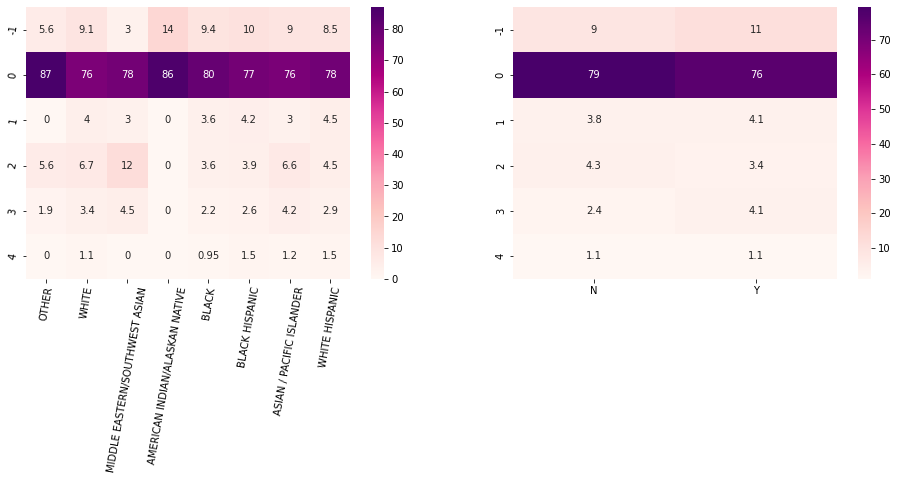

In [148]:
fig, ax = plt.subplots(1,2,figsize=(16,5))

# left plot
sns.heatmap(fig5a_df, cmap='RdPu', annot=True, ax=ax[0])
ax[0].tick_params(labelrotation=80)

# right plot
sns.heatmap(fig5b_df, cmap='RdPu', annot=True, ax=ax[1])

# 4. Sentiment Analysis with Vader + Feature Importance with RandomForest

This section uses pre-trained sentiment analysis model provided by `nltk` to measure sentiment of `DEMEANOR_OF_PERSON_STOPPED_v2` column. It then uses a Ranfom Forest model to determine the most important feautres when predicting sentiment

In [149]:
sentiment_df = df.copy()

In [150]:
# initialise sentiment analysis model
sid = SentimentIntensityAnalyzer()

sentiment_df['sentiment'] = sentiment_df['DEMEANOR_OF_PERSON_STOPPED_v2'].apply(lambda x: sid.polarity_scores(x)['compound'])

# get the mean sentiment for each race group
fig6a_df = pd.DataFrame(sentiment_df.groupby('SUSPECT_RACE_DESCRIPTION').mean()['sentiment']\
    .rename('Mean Sentiment')\
    .sort_values())

fig6a_df['Mean Sentiment'] = round(fig6a_df['Mean Sentiment'], 3)

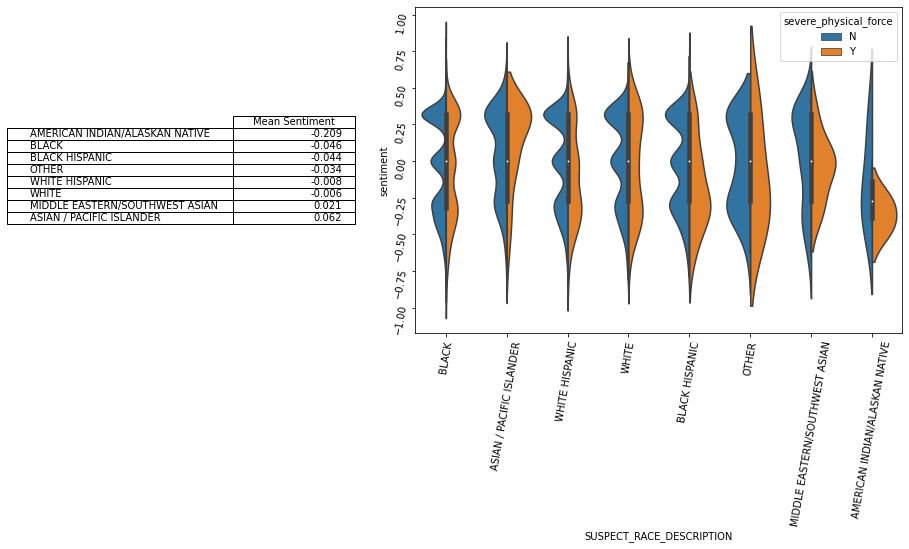

In [151]:
fig, ax = plt.subplots(1,2,figsize=(12,6), gridspec_kw={'width_ratios': [1, 4]})

# left plot
ax[0].table(cellText=fig6a_df.values, colLabels=fig6a_df.columns, rowLabels=fig6a_df.index, loc='center')
ax[0].axis('off')
ax[0].axis('tight')

# plot distribution of sentiment by race and use of severe physical force
sns.violinplot(data=sentiment_df, x="SUSPECT_RACE_DESCRIPTION", y="sentiment", hue='severe_physical_force', split=True, ax=ax[1])
plt.tick_params(labelrotation=80)

### 4.1 Discretize sentiment scores into 5 bins, corresponding to "Very Negative", "Negative", "Neutral", "Positive", and "Very Positive" sentiment

In [152]:
# equally distribute the sentiment column to 5 bins
dist = np.linspace(sentiment_df['sentiment'].min(), sentiment_df['sentiment'].max(), 6)

sentiment_cat = []

for _, row in sentiment_df.iterrows():
    if (row['sentiment'] >= dist[0]) and (row['sentiment'] < dist[1]):
        sentiment_cat.append('Very Negative')
    elif (row['sentiment'] >= dist[1]) and (row['sentiment'] < dist[2]):
        sentiment_cat.append('Negative')
    elif (row['sentiment'] >= dist[2]) and (row['sentiment'] < dist[3]):
        sentiment_cat.append('Neutral')
    elif (row['sentiment'] >= dist[3]) and (row['sentiment'] < dist[4]):
        sentiment_cat.append('Positive')
    elif (row['sentiment'] >= dist[4]) and (row['sentiment'] <= dist[5]):
        sentiment_cat.append('Very Positive')

sentiment_df['sentiment_category'] = sentiment_cat

#### 4.2 Feature selection for Classifier training

The following columns were dropped from the dataset with the provided justification

<br>

| Dropped Column                | Justification                                                      |
|-------------------------------|--------------------------------------------------------------------|
| STOP_ID                       | Perceived to lack relevance to sentiment                           |
| STOP_FRISK_DATE               | Perceived to lack relevance to sentiment                           |
| SUSPECT_ARREST_OFFENSE        | Mostly null values                                                 |
| DEMEANOR_OF_PERSON_STOPPED    | Encoded as part of sentiment                                       |
| DEMEANOR_OF_PERSON_STOPPED_v2 | Encoded as part of sentiment                                       |
| demeanor_tokens               | Encoded as part of sentiment                                       |
| SUSPECT_REPORTED_AGE          | Perceived to lack relevance to sentiment; encoded as part of build |
| SUSPECT_HEIGHT                | Encoded as part of body build type                                 |
| SUSPECT_WEIGHT                | Encoded as part of body build type                                 |
| SUSPECT_EYE_COLOR             | Perceived to lack relevance to sentiment                           |
| SUSPECT_HAIR_COLOR            | Perceived to lack relevance to sentiment                           |
| sentiment                     | Encoded as part of sentiment category                              |
| race_census                   | Encoded as part of SUSPECT_RACE_DESCRIPTION                        |


In [153]:
rf_columns = ['ISSUING_OFFICER_RANK','SUPERVISING_OFFICER_RANK',
              'SUSPECT_ARRESTED_FLAG', 'SUSPECTED_CRIME_DESCRIPTION','FRISKED_FLAG',
              'SEARCHED_FLAG', 'ASK_FOR_CONSENT_FLG', 'CONSENT_GIVEN_FLG',
              'OTHER_CONTRABAND_FLAG', 'FIREARM_FLAG', 'KNIFE_CUTTER_FLAG',
              'OTHER_WEAPON_FLAG', 'WEAPON_FOUND_FLAG', 'PHYSICAL_FORCE_CEW_FLAG',
              'PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG',
              'PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG',
              'PHYSICAL_FORCE_OC_SPRAY_USED_FLAG', 'PHYSICAL_FORCE_OTHER_FLAG',
              'PHYSICAL_FORCE_RESTRAINT_USED_FLAG',
              'PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG',
              'PHYSICAL_FORCE_WEAPON_IMPACT_FLAG',
              'SUSPECT_SEX', 'SUSPECT_RACE_DESCRIPTION',
              'SUSPECT_BODY_BUILD_TYPE', 'STOP_LOCATION_BORO_NAME',
              'severe_physical_force','sentiment_category']

rf_df = sentiment_df[rf_columns].copy()

In [154]:
# Use label encoder to transform categorical columns
for col in rf_df:
    le = preprocessing.LabelEncoder()
    rf_df[col] = le.fit_transform(rf_df[col])

### 4.3 Train a Random Forrest Model to predict sentiment

NB The dataset is not divided into a training and test set as the goal of this exercise is to assess feature importance rather than model accuracy

In [155]:
# initialise random forest
rf_model = RandomForestClassifier()

# fit to complete dataset
X = rf_df.drop('sentiment_category', axis=1)
y = rf_df['sentiment_category']
rf_model.fit(X, y)

rf_score = rf_model.score(X, y)
print(f'Model accuracy score: {round(rf_score,2)}')

Model accuracy score: 0.89


### 4.4 Assess feature importance to sentiment prediction and plot

<AxesSubplot:xlabel='feature_importance_score'>

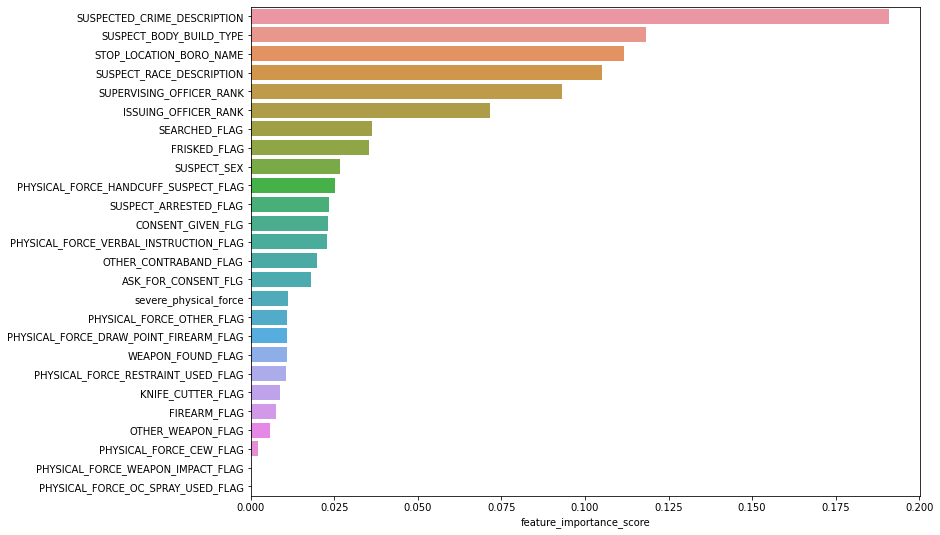

In [156]:
# get feature importance and format to dataframe
rf_feat_df = pd.DataFrame(rf_model.feature_importances_, columns = ['feature_importance_score'],
                          index=X.columns).\
                            sort_values(['feature_importance_score'], ascending=False)
plt.figure(figsize=(12,9))
sns.barplot(rf_feat_df, y=rf_feat_df.index, x='feature_importance_score')

## Appendix: Train a Random Forest model to predict use of severe physical force

NB this was not included in the report as the use of 'severe physical force' was restricted to ~6.5% of the stops, which made for a very imbalanced dataset for training. Additionally, the model accuracy was reported to be about 98%, which is indicative of potential over-fitting of the model. It is left in this supplementary document as an interesting addendum.

In [157]:
rf_columns = ['ISSUING_OFFICER_RANK','SUPERVISING_OFFICER_RANK',
              'SUSPECT_ARRESTED_FLAG', 'SUSPECTED_CRIME_DESCRIPTION','FRISKED_FLAG',
              'SEARCHED_FLAG', 'ASK_FOR_CONSENT_FLG', 'CONSENT_GIVEN_FLG',
              'OTHER_CONTRABAND_FLAG', 'FIREARM_FLAG', 'KNIFE_CUTTER_FLAG',
              'OTHER_WEAPON_FLAG', 'WEAPON_FOUND_FLAG',
              'SUSPECT_SEX', 'SUSPECT_RACE_DESCRIPTION',
              'SUSPECT_BODY_BUILD_TYPE', 'STOP_LOCATION_BORO_NAME',
              'severe_physical_force','sentiment_category']

rf_df_2 = rf_df[rf_columns].copy()


# initialise random forest
rf_model_2 = RandomForestClassifier()

# fit to complete dataset
rf_model_2.fit(rf_df_2.drop('severe_physical_force', axis=1), rf_df_2['severe_physical_force'])

rf_score = rf_model_2.score(rf_df_2.drop('severe_physical_force', axis=1), rf_df_2['severe_physical_force'])
print(f'Model accuracy score: {round(rf_score,2)}')

Model accuracy score: 0.98


<AxesSubplot:xlabel='feature_importance_score'>

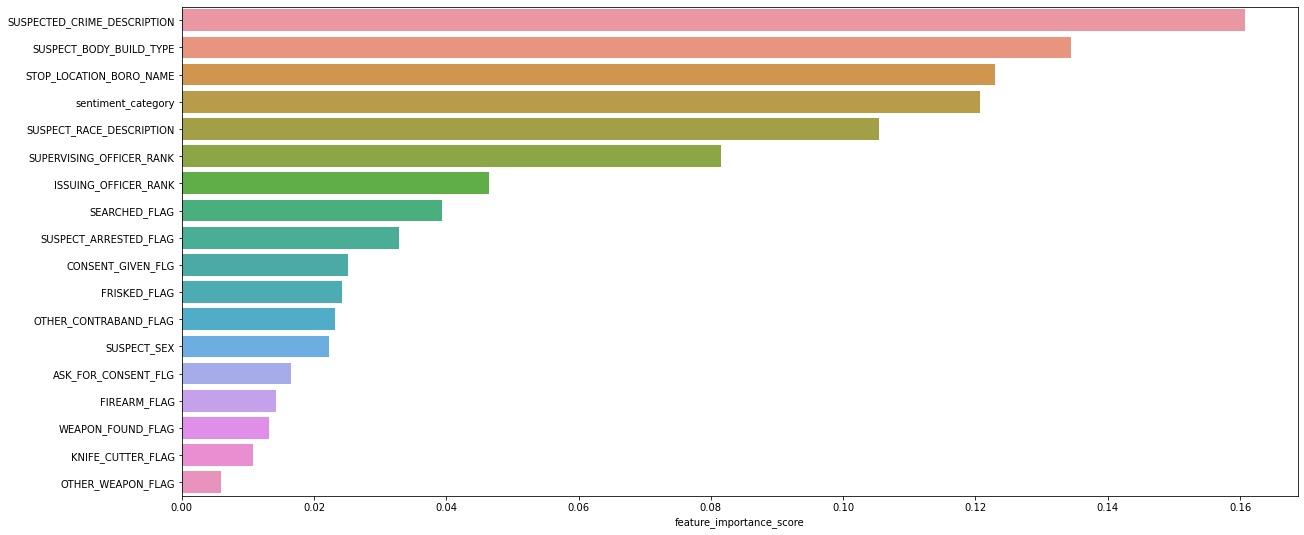

In [158]:
# get feature importance and format to dataframe
rf_feat_df_2 = pd.DataFrame(rf_model_2.feature_importances_, columns = ['feature_importance_score'],
                          index=rf_df_2.drop('severe_physical_force', axis=1).columns).\
    sort_values(['feature_importance_score'], ascending=False)
plt.figure(figsize=(20,9))
sns.barplot(rf_feat_df_2, y=rf_feat_df_2.index, x='feature_importance_score')

As in the previous model, it is seen that the most important features in predicting if severe physical force was used were the `SUSPECTED_CRIME_DESCRIPTION`, `SUSPECT_BODY_BUILD_TYPE` and `STOP_LOCATION_BORO_NAME`. In both cases, it is worth noting that the propensity to use 'severe force' and the sentiment used to describe the suspect was more dependant on the characteristics of the suspect, the location of the stop, and the officer's interpretation of the scene, as opposed to the actual innocence of the suspect and what was found on the scene.